In [8]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import LinearConstraint
import pickle


with open('allbids_new.pkl', 'rb') as f:
    allbids = pickle.load(f)

def itemsWon(others, bid, n):
  # returns the number of items obtained submitting a bid vector 'bid' when the competing bids are 'others'
  others = others.flatten()
  r = np.r_[others, bid]
  r = np.sort(r)[::-1][:n]
  return min(np.sum(r == bid[0]), bid.shape[0])

def preProcessActualData(n1, n2, T, data=allbids):
  '''
  Generates a random bid history A, valuation curve v.
  Returns a reward matrix P in which P[i, j] is value obtained in round j by bidding w_i.
  '''
  datalen = len(data)
  T = min(T, datalen)
  assert n1 >= n2, 'n1 must be greater than or equal to n2'
  A = np.zeros((n1, T))
  idx = np.random.choice(datalen, T, replace=False)
  for i, id in enumerate(idx):
    A[:, i] = data[id]['bids'][:n1]
  A = np.sort(A, axis=0)[::-1]
  v = np.random.random(n2)
  v = np.sort(v)[::-1]
  w = np.cumsum(v) / np.arange(1, n2+1)

  P = np.zeros((n2, T))
  for i in range(n2):
    bid = np.asarray([w[i]]*(i+1))
    for j in range(T):
      it = itemsWon(A[:, j], bid, n1)
      if it:
        P[i, j] = it * w[it-1]
  return P, v, w

def runLP(P, n, T, k, data=allbids):
  '''
  Solves the relaxed LP. n = n2 here.
  In sims, the relaxed LP attains the same solution as the MILP, i.e., integrality gap is 1.
  So, we use LP for faster computation.
  '''
  T = min(T, len(data))
  err = []
  c = np.r_[P.T.flatten(), np.zeros(n)]
  M = np.eye(T+1); M[-1, -1] = 0
  Z = np.kron(M, np.ones(n)); Z = Z[:-1]
  r = np.r_[np.zeros(n*T), np.ones(n)]
  Y = np.c_[np.eye(n*T), np.tile(-np.eye(n),(T, 1))]
  Y = np.r_[Y, np.expand_dims(r, axis=0)]
  b = np.r_[np.zeros(n*T), [k]]
  b1 = np.ones(T)

  sol = sp.optimize.linprog(-c, A_ub=Y, b_ub=b, A_eq=Z, b_eq=b1, bounds=(0,1))
  if sol.x is None:
    err.append((P, n, T, k))
    return None, None, None, None, err

  ids = sol.x[-n:]
  y = sol.x[:-n]
  opt = -sol.fun
  return y, ids, opt, (sol.ineqlin, sol.eqlin), err

def runMILP(P, n, T, k, data=allbids):
  '''
  Solves the MILP. n = n2 here.
  '''
  T = min(T, len(data))
  err = []
  c = np.r_[P.T.flatten(), np.zeros(n)]
  M = np.eye(T+1); M[-1, -1] = 0
  Z = np.kron(M, np.ones(n)); Z = Z[:-1]
  r = np.r_[np.zeros(n*T), np.ones(n)]
  Y = np.c_[np.eye(n*T), np.tile(-np.eye(n),(T, 1))]
  Y = np.r_[Y, np.expand_dims(r, axis=0)]
  b = np.r_[np.zeros(n*T), [k]]
  b1 = np.ones(T)

  b_ = np.full_like(b, -np.inf)
  ub = np.r_[b, b1]
  lb = np.r_[b_, b1]
  A = np.r_[Y, Z]

  constraints = LinearConstraint(A, lb, ub)
  bounds = sp.optimize.Bounds(0, 1)  # 0 <= x_i <= 1
  integrality = np.full_like(c, True)  # x_i are integers
  sol = sp.optimize.milp(-c, constraints=constraints, bounds=bounds, integrality=integrality)

  if sol.x is None:
    err.append((P, n, T, k))
    return None, None, (None, None), err

  ids = sol.x[-n:]
  y = sol.x[:-n]
  opt = -sol.fun
  return y, ids, opt, (sol.success, sol.success), err

In [2]:
shuffle = False
deltaList = []
niter = 10
kmax = 10
optMatrix = np.zeros((niter, kmax))
Tlist = []
nlist, n1list = [], []
optUBList = np.zeros_like(optMatrix)
for i in tqdm(range(niter)):
  n = np.random.randint(10, 80)
  n1 = np.random.randint(n, 100)
  T = np.random.randint(100, 300)
  nlist.append(n)
  n1list.append(n1)
  Tlist.append(T)
  print(n1, n, T)
  P, v, w = preProcessActualData(n1, n, T)
  opt_ub = P.max(axis=0).sum()

  if shuffle:
      np.random.shuffle(P)
  for k in range(1, kmax + 1):
    y, ids, opt, (ineqlin, eqlin), err = runLP(P, n, T, k)
    optMatrix[i, k-1] = opt
    optUBList[i, k-1] = opt_ub / opt
    if err:
      print(err, v, w)
      break

  0%|          | 0/10 [00:00<?, ?it/s]

99 61 141


 10%|█         | 1/10 [00:20<03:03, 20.42s/it]

72 45 174


 20%|██        | 2/10 [00:36<02:22, 17.77s/it]

95 64 258


 30%|███       | 3/10 [01:46<04:51, 41.65s/it]

77 74 188


 40%|████      | 4/10 [02:34<04:26, 44.36s/it]

98 32 188


 50%|█████     | 5/10 [02:44<02:39, 31.92s/it]

71 62 169


 60%|██████    | 6/10 [03:13<02:02, 30.67s/it]

86 22 186


 70%|███████   | 7/10 [03:17<01:06, 22.10s/it]

52 49 102


 80%|████████  | 8/10 [03:25<00:35, 17.50s/it]

77 28 143


 90%|█████████ | 9/10 [03:29<00:13, 13.36s/it]

87 60 245


100%|██████████| 10/10 [04:25<00:00, 26.51s/it]


In [3]:
np.save('optMatrix.npy', optMatrix)
np.save('optUBList.npy', optUBList)

In [4]:
optUBList = np.load('optUBList.npy')
optMatrix = np.load('optMatrix.npy')
result = optMatrix / optMatrix[:, 0][:, np.newaxis]

Text(0, 0.5, 'opt_m/opt_1')

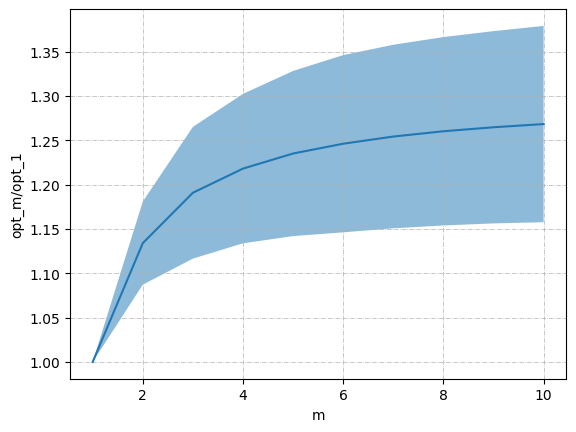

In [7]:
plt.grid(which='major', linestyle='-.', linewidth='0.5')
plt.plot(np.arange(1, 11), result.mean(axis=0))
plt.fill_between(np.arange(1, 11), result.mean(axis=0) - result.std(axis=0), result.mean(axis=0) + result.std(axis=0), alpha=0.5)
plt.xlabel('m')
plt.ylabel('opt_m/opt_1')

Text(0, 0.5, 'opt_non_UF_UB/opt_UF')

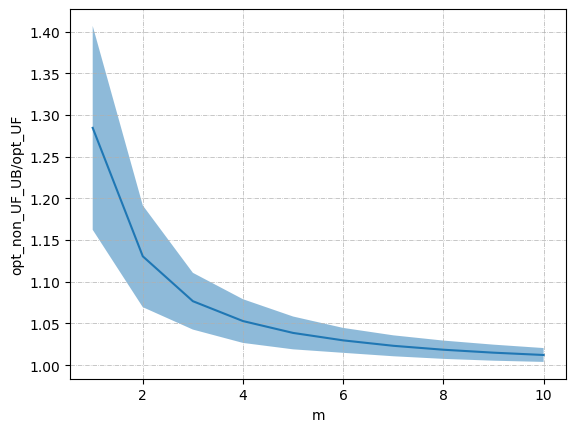

In [6]:
plt.grid(which='major', linestyle='-.', linewidth='0.5')
plt.plot(np.arange(1, 11), optUBList.mean(axis=0))
plt.fill_between(np.arange(1, 11), optUBList.mean(axis=0) - optUBList.std(axis=0), optUBList.mean(axis=0) + optUBList.std(axis=0), alpha=0.5)
plt.xlabel('m')
plt.ylabel('opt_non_UF_UB/opt_UF')